This notebook contains the minimul code of recoverying tiny 2D surface titls from dual-shutter camera recordings. 


Our rolling-shutter(rs) and global-shutter(gs) camera image five speckle columns at the same time, shown below(Rolling shutter frames on the left):

![speckle-image](assets/speckle_image.png)


We can recovery a 2D tilts vector for each row of each rolling-shutter frames. Since the rolling-shutter camera can operates at up to 63K rows per second, thus we can get an extremelly high recovery frequency. 

The recovery contain five major steps: 
1. Align the rolling-shutter frames and global-shutter frames with an homography. 
2. Compute the per-frame 2D shift of global-shutter cameras. 
3. For each rolling-shutter frame, find one reference global frames. (the one closest in time)
4. For each row of the rolling-shutter frame, perform cross-correlation between the reference global-shutter frame to get the local 2D tilts. 
5. Translate the local 2D tilts by the shift of global-shutter frames. 





In [1]:
import os
import numpy as np
import time

import matplotlib.pyplot as plt

from src.ds_tilts_recovery.opencv_video_utils import videoPlayerRecording
from src.ds_tilts_recovery.data_utils import load_recording
from src.ds_tilts_recovery.image_processing import *

from src.ds_tilts_recovery.recovery_functions import (find_closets_reference_frames, run_recovery,
    find_frame_translation_phase_corr, compute_CAM2_translations_v2, compute_coarse_xy_using_phase_correlation)


# Load recorded videos from global and rolling shutter camera pairs

In [3]:
data_dir = "data/raw_speckle_videos/point_4_exp_2_12_frame_6"
load_file_path = os.path.join(data_dir, "RECORDING.npz")

frame_recording, run_opt, experiment_name = load_recording(load_file_path)

Capture parameters:
| Parameter                   | Value                         | Parameter                   | Value                         |
| -------------               | :-------------:               | -------------               | :-------------:               |
| exposure_eff                | [0.04084211 0.04129757]       | frame_rate_eff              | [ 70.52919166 134.01912489]   |

Experiment:
output_dir:         /home/tyzhang/LargeFiles/vibration/camera_data_raw/plasticboard/Sep12_circle_addframe/point_4_exp_2_12_09_Time_18_13_38_frame_6
recovery_dir:       None
export_sound_dir:   None

Loaded 42 data samples


## Visualize the recordings

In [4]:
def create_frame_show(frames,resize_factor=1,apply_debayer=0,is_draw_ROI=0,apply_rotation=0,run_opt=None):        
        for i in range(len(frames)):
            frames[i] = convert_frame_to_uint8(frames[i])
            if apply_debayer:
                frames[i] = cv2.cvtColor(frames[i],cv2.COLOR_BAYER_BG2BGR)
            if is_draw_ROI:
                draw_ROIs(frames[i],run_opt['AOIs_list'],color_val=65535)
                
                
        if apply_rotation:
            frames[1] = cv2.flip(frames[1],flipCode = 1) 
        frame_show    = combine_frames_for_show(frames,1.0,0)                    
        frame_show    = cv2.resize(frame_show,None,fx = resize_factor, fy = resize_factor)
        
        if len(frames)>1:
            cv2.line(frame_show,(frames[0].shape[1],0),
                                (frames[0].shape[1],frames[0].shape[0]), 
                                (255,255,255),1)
            
        return frame_show
        
def get_frameshow(data_counter,is_draw_ROI=0,apply_rotation = 0):
    frames = []
    for i in range(len(frame_recording)):
        if i==0:
            frames.append(frame_recording[i][data_counter].copy())
        else:
            data_counter_cam2 = int(data_counter * run_opt['capture_params']['frame_rate_eff'][1]/run_opt['capture_params']['frame_rate_eff'][0])
            frames.append(frame_recording[i][data_counter_cam2].copy())
            
    frame_show = create_frame_show(frames,is_draw_ROI=is_draw_ROI,apply_rotation=1,apply_debayer=run_opt['is_color_camera'],
                                   run_opt=run_opt)#[:,run_opt['speckle_ROI'][0]:run_opt['speckle_ROI'][1]]
    #frame_show = frame_show.T
    return frame_show

show_frame_number = 1

N_frames           = frame_recording[0].shape[0]
resize_factor      = 0.75
get_frame_func     = get_frameshow

video_player       = videoPlayerRecording(get_frame_func,N_frames,resize_factor=resize_factor)
video_player.play_video(move_window=0,show_frame_number=show_frame_number)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread

# Aligned global and rolling shuter camera


The rolling-shutter camera and global-shutter camera images the roughtly same speckles, and relates to each other after a homography.  We need to caliberate this homography to proceed the tilts recovery. 

The homography can be computed by using SIFT to find keypoints and correspondences, then solve an robust estimation.  We skip this process and direct load the frames after homography alignment. 


In [7]:
cropped_aligned_roi_path = os.path.join(data_dir, "cropped_and_warpped_frames.npz")
cropped_aligned_frames = np.load(cropped_aligned_roi_path)

# rolling-shutter, global-shutter frames
video_pp, video_pp_cam2 = cropped_aligned_frames["video_pp"], cropped_aligned_frames["video_pp_cam2"]
cropped_frames_list = [video_pp, video_pp_cam2]

In [16]:
# visualize the global shutter frames after aligned. 

def get_frameshow(data_counter,is_draw_ROI=0,apply_rotation = 0):
    frame_show = video_pp_cam2[data_counter].copy()    
    frame_show = (frame_show*255).clip(0,255).astype('uint8')
    return frame_show.T

N_frames           = video_pp_cam2.shape[0]
resize_factor      = 1
get_frame_func     = get_frameshow
video_player       = videoPlayerRecording(get_frame_func,N_frames,resize_factor=1.4)
video_player.play_video(move_window=0,show_frame_number=1)

QObject::moveToThread: Current thread (0x2fcefe0) is not the object's thread (0x2d939d0).
Cannot move to target thread (0x2fcefe0)

QObject::moveToThread: Current thread (0x2fcefe0) is not the object's thread (0x2d939d0).
Cannot move to target thread (0x2fcefe0)

QObject::moveToThread: Current thread (0x2fcefe0) is not the object's thread (0x2d939d0).
Cannot move to target thread (0x2fcefe0)

QObject::moveToThread: Current thread (0x2fcefe0) is not the object's thread (0x2d939d0).
Cannot move to target thread (0x2fcefe0)

QObject::moveToThread: Current thread (0x2fcefe0) is not the object's thread (0x2d939d0).
Cannot move to target thread (0x2fcefe0)

QObject::moveToThread: Current thread (0x2fcefe0) is not the object's thread (0x2d939d0).
Cannot move to target thread (0x2fcefe0)

QObject::moveToThread: Current thread (0x2fcefe0) is not the object's thread (0x2d939d0).
Cannot move to target thread (0x2fcefe0)

QObject::moveToThread: Current thread (0x2fcefe0) is not the object's thread

# Compute 2D shifts of global shutter camera


We first compute the 2D shifts of global-shutter cameras, this can be done using cross-correlation between ajacent global-shutter frames. 


----- Computing shifts -----


100%|████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.41it/s]


Not removing bad frames


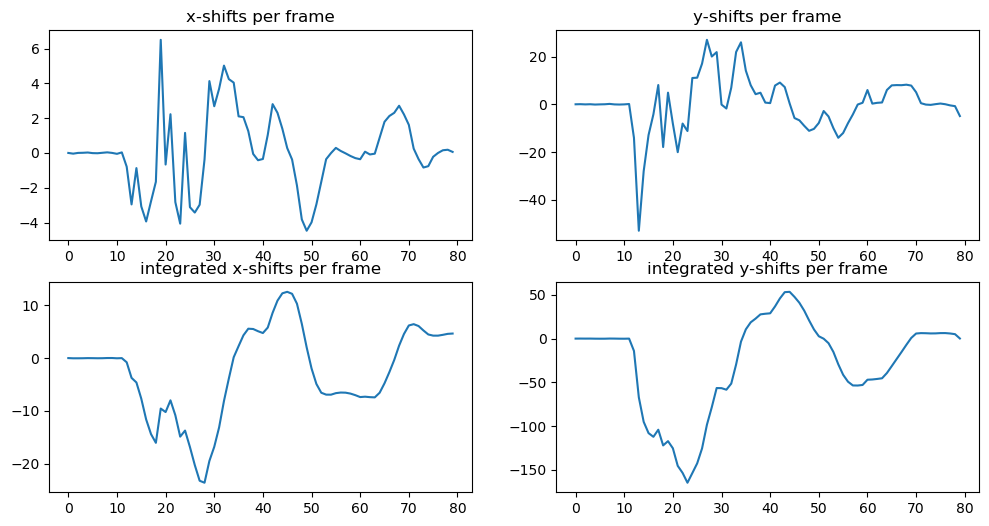

In [8]:
W_margin  = 25 # px
W_matrix  = np.zeros_like(video_pp_cam2[0])
W_matrix[:,W_margin:-W_margin] = 1


all_reference_shifts, video_pp_cam2_debug,succ_frames = compute_CAM2_translations_v2(video_pp_cam2,
                                                                      [find_frame_translation_phase_corr], #find_frame_translation_ECC_grad
                                                                      run_opt,
                                                                      W_matrix = W_matrix.astype('uint8'),
                                                                      debug=1) 

run_opt['ref_time_stamps'] = run_opt['time_stamps'][1]
print(f"Not removing bad frames")
if 1: #PLOT
    plt.figure(figsize=(12,6))
    plt.subplot(221)
    plt.plot(all_reference_shifts[:,0])
    plt.title('x-shifts per frame')
    plt.subplot(222)
    plt.plot(all_reference_shifts[:,1])
    plt.title('y-shifts per frame')
    plt.subplot(223)
    plt.plot(np.cumsum(all_reference_shifts[:,0]))
    plt.title('integrated x-shifts per frame')
    plt.subplot(224)
    plt.plot(np.cumsum(all_reference_shifts[:,1]))
    plt.title('integrated y-shifts per frame')


## Visualize the shifted global-shutter frames

The top row shows the original global-shutter recordings, and the bottom row shows the recordings after shifted. 

![gs-frame26](assets/gs-shift-frame26.png)
![gs-frame27](assets/gs-shift-frame27.png)


In [10]:


def get_frameshow(data_counter,is_draw_ROI=0,apply_rotation = 0):
    frame_show      = video_pp_cam2[data_counter].copy()
    frame_show_cam2 = video_pp_cam2_debug[data_counter].copy()
    frame_show      = np.hstack((frame_show,frame_show_cam2))
    frame_show      = (frame_show*255).clip(0,255).astype('uint8')
        
    
    return frame_show.T

N_frames           = video_pp_cam2.shape[0]
resize_factor      = 1
get_frame_func     = get_frameshow
video_player       = videoPlayerRecording(get_frame_func,N_frames,resize_factor=1.4)
video_player.play_video(move_window=0,show_frame_number=1)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread (0x1364bf0).
Cannot move to target thread (0x22eb8d0)

QObject::moveToThread: Current thread (0x22eb8d0) is not the object's thread

# Compute 2D shifts with one reference frame

Recovery a 2D tilts vector for each row in the rolling-shutter frame.  It is done in three steps: 

1. For each rolling-shutter frame, find the closest reference global frame.
2. For each pair of (rolling-shutter frame, global-shutter frame). We loop of each row of the rolling-shutter frame, and compute the phase correlation between the row and the global-shutter frame to get a 2D shift vector.
3. Since the global shutter frame is also moving, we need to account for it by translate the recovered shifts using all_reference_shifts (which is computed by cells above)


In [27]:
run_opt['recovery'] = {}
run_opt['recovery']['motion_model_x_range']      = [-80,80,1, 0.1]
run_opt['recovery']['motion_model_y_range']      = [-80,80,1, 0.1]
run_opt['recovery']['graph_cut_Lambda']              = [1000,100]


frame_index_list = [5, 6, 7]

x_vec, y_vec = run_recovery(frame_index_list,video_pp, video_pp_cam2, all_reference_shifts, run_opt)



  0%|                                                                                              | 0/3 [00:00<?, ?it/s]

(944, 165) (1,)


 33%|████████████████████████████▋                                                         | 1/3 [00:01<00:02,  1.05s/it]

(944, 165) (1,)


 67%|█████████████████████████████████████████████████████████▎                            | 2/3 [00:02<00:01,  1.03s/it]

(944, 165) (1,)


100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

Done recovering 0.05 min


## Visualize the computed shifts


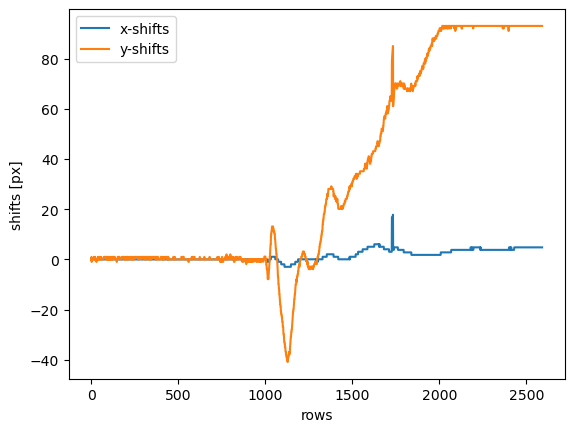

In [30]:
plt.figure()

x_show = x_vec.reshape(-1,1)
y_show = y_vec.reshape(-1,1)

x_in_frames = np.arange(len(x_show))

plt.plot(x_in_frames, x_show, label="x-shifts")
plt.plot(x_in_frames, y_show, label="y-shifts")

plt.ylabel("shifts [px]")
plt.xlabel("rows")

plt.legend()

plt.show()